In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

import os

In [2]:
# Initialize SparkSession
os.environ['SPARK_HOME'] = 'C:/spark-3.5.0-bin-hadoop3'
os.environ['PATH'] += 'C:/spark-3.5.0-bin-hadoop3/bin'
spark = SparkSession.builder \
    .appName("Wind Power Prediction") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.memory", "1g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()



In [3]:
# Load data
df = spark.read.csv('../Dataset/T1.csv', header=True, inferSchema=True)


In [4]:
# Remove irrelevant columns
df = df.drop('Date/Time', 'Theoretical_Power_Curve (KWh)')

In [5]:
print(df)

DataFrame[LV ActivePower (kW): double, Wind Speed (m/s): double, Wind Direction (°): double]


In [6]:
# Normalize features
feature_columns = ['Wind Direction (°)', 'Wind Speed (m/s)']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

In [7]:
# Define models
models = {
    'XGBoost': GBTRegressor(labelCol='LV ActivePower (kW)'),
    'Random Forest': RandomForestRegressor(labelCol='LV ActivePower (kW)'),
    'Linear Regression': LinearRegression(labelCol='LV ActivePower (kW)'),
    'Decision Tree': DecisionTreeRegressor(labelCol='LV ActivePower (kW)')
}

In [8]:
# Define evaluator
evaluator = RegressionEvaluator(labelCol="LV ActivePower (kW)", predictionCol="prediction", metricName="r2")

In [9]:
# Split data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [10]:
for name, model in models.items():
    pipeline = Pipeline(stages=[assembler, scaler, model])
    paramGrid = ParamGridBuilder().build()
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=5)
    cvModel = crossval.fit(train_data)
    predictions = cvModel.transform(test_data)
    r2 = evaluator.evaluate(predictions)
    print(f'R2-{name}: {r2}')

R2-XGBoost: 0.9163568488646847
R2-Random Forest: 0.9087736937295984
R2-Linear Regression: 0.8335548083227226
R2-Decision Tree: 0.9137755646017032


In [11]:
# Stop SparkSession
spark.stop()

In [2]:
! pip install findspark

Using cached findspark-2.0.1-py2.py3-none-any.whl (4.4 kB)


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


R2-XGBoost: 0.9179209624304278


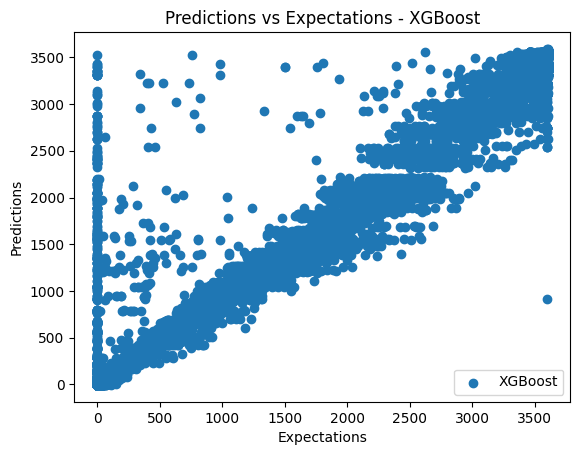

C:\Users\manoj\AppData\Local\Temp\ipykernel_28860\3098963926.py:74: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((expectations - predictions) / expectations))


Mean Absolute Percent Error (XGBoost): inf
R2-Random Forest: 0.9063155313901088


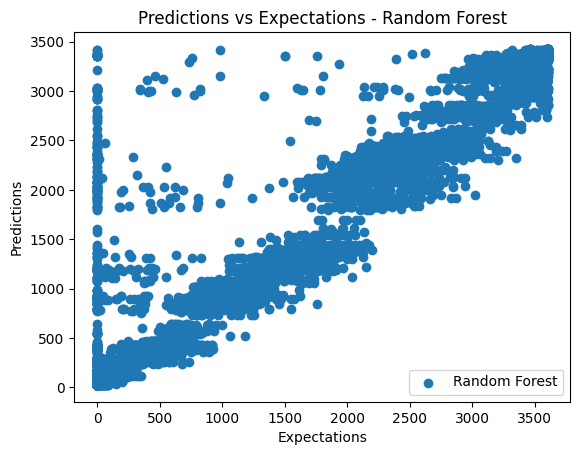

Mean Absolute Percent Error (Random Forest): inf
R2-Linear Regression: 0.8335548083227226


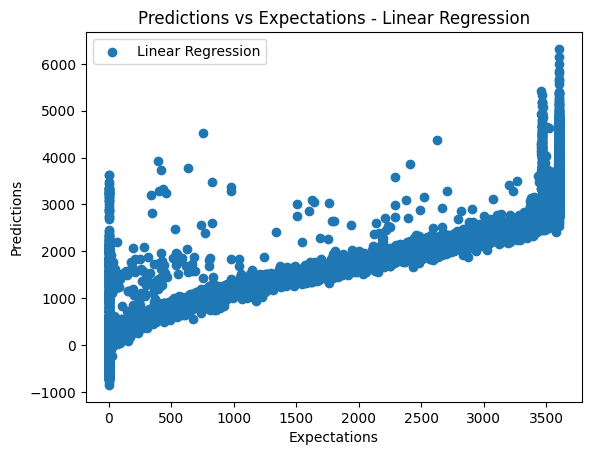

Mean Absolute Percent Error (Linear Regression): inf
R2-Decision Tree: 0.9137816673439929


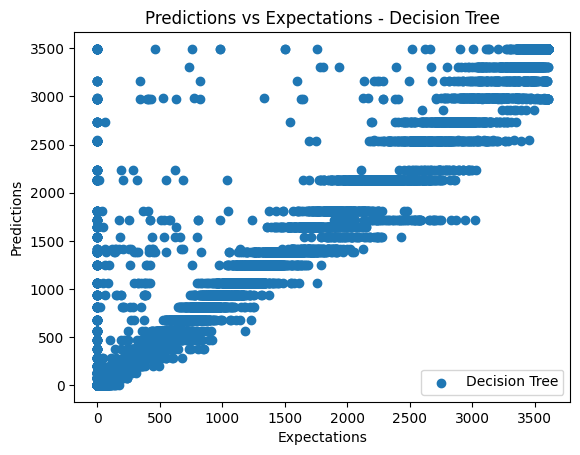

Mean Absolute Percent Error (Decision Tree): inf


In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

import findspark
import matplotlib.pyplot as plt
import numpy as np

# Specify the Spark home directory and version
findspark.init('C:/spark/spark-3.5.1-bin-hadoop3/spark-3.5.1-bin-hadoop3')

# Configure Spark to use a master URL and set up the application name
master_url = "spark://192.168.106.215:7077"
app_name = "spark-basic"

# Create a SparkSession with the specified master and app name
spark = SparkSession.builder.master(master_url).appName(app_name).getOrCreate()

# Load data from a local CSV file
df = spark.read.csv('../Dataset/T1.csv', header=True, inferSchema=True)

# Remove irrelevant columns
df = df.drop('Date/Time', 'Theoretical_Power_Curve (KWh)')

# Define feature and target columns
feature_columns = ['Wind Direction (°)', 'Wind Speed (m/s)']
target_col = 'LV ActivePower (kW)'

# Normalize features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Define models dictionary
models = {
    'XGBoost': GBTRegressor(labelCol=target_col),
    'Random Forest': RandomForestRegressor(labelCol=target_col),
    'Linear Regression': LinearRegression(labelCol=target_col),
    'Decision Tree': DecisionTreeRegressor(labelCol=target_col)
}

# Define evaluator
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")

# Split data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Parallel processing for model training
def fit_pipeline(model, train_data):
    pipeline = Pipeline(stages=[assembler, scaler, model])
    return pipeline.fit(train_data)

trained_models = [fit_pipeline(model, train_data) for model in models.values()]

for name, model in zip(models.keys(), trained_models):
    predictions = model.transform(test_data)
    r2 = evaluator.evaluate(predictions)
    print(f'R2-{name}: {r2}')

    # Extract predictions and expectations as NumPy arrays
    expectations = np.array(predictions.select(target_col).collect())
    predictions = np.array(predictions.select("prediction").collect())

   

    # Plot predictions vs. expectations
    plt.scatter(expectations, predictions, label=name)
    plt.title(f'Predictions vs Expectations - {name}')
    plt.xlabel('Expectations')
    plt.ylabel('Predictions')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percent Error (MAPE)
    mape = np.mean(np.abs((expectations - predictions) / expectations))
    print(f'Mean Absolute Percent Error ({name}): {mape}')

# Stop SparkSession
spark.stop()


In [9]:
print(expectations)

[[-9.58999574e-01]
 [-7.34467685e-01]
 [-6.28802896e-01]
 ...
 [ 3.60450903e+03]
 [ 3.60458301e+03]
 [ 3.60459692e+03]]
